 # Time Series
 
* This notebook will be comparing and describing some techniques for forecasting time series.
* The dataset used here is from a public Shampoo Sales Data.

### 1. Import Libraries and Read the Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pylab import rcParams
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../../data/raw/shampoo.csv")
df = df.rename(columns = {'Month': "Time"})
df = df.rename(columns = {'Sales' : "Cost"})

In [3]:
datetime_series = pd.Series(
    pd.date_range("2020-01-01", periods=365, freq=None)
)
df['timestamp'] = datetime_series

In [4]:
df = df.drop(columns = 'Time')
df = df.reindex(columns=['timestamp', 'Cost'])

In [5]:
df

,timestamp,Cost
0,2020-01-01,266.0
1,2020-01-02,145.9
2,2020-01-03,183.1
3,2020-01-04,119.3
4,2020-01-05,180.3
5,2020-01-06,168.5
6,2020-01-07,231.8
7,2020-01-08,224.5
8,2020-01-09,192.8
9,2020-01-10,122.9


### 2. Exploratory Data Analysis

In [6]:
print("Shape of the DataFrame" , df.shape , "\n")
print("Statistics of the DataFrame", "\n")
display(df.describe())
print("\n")
print("Number of unique values per feature", "\n")
display(df.nunique())
print("\n")
print("Null values :")
print("\n")
print(df.isnull().sum())

Shape of the DataFrame (36, 2) 

Statistics of the DataFrame 



,Cost
count,36.000000
mean,312.600000
std,148.937164
min,119.300000
25%,192.450000
50%,280.150000
75%,411.100000
max,682.000000




Number of unique values per feature 



timestamp    36
Cost         36
dtype: int64



Null values :


timestamp    0
Cost         0
dtype: int64


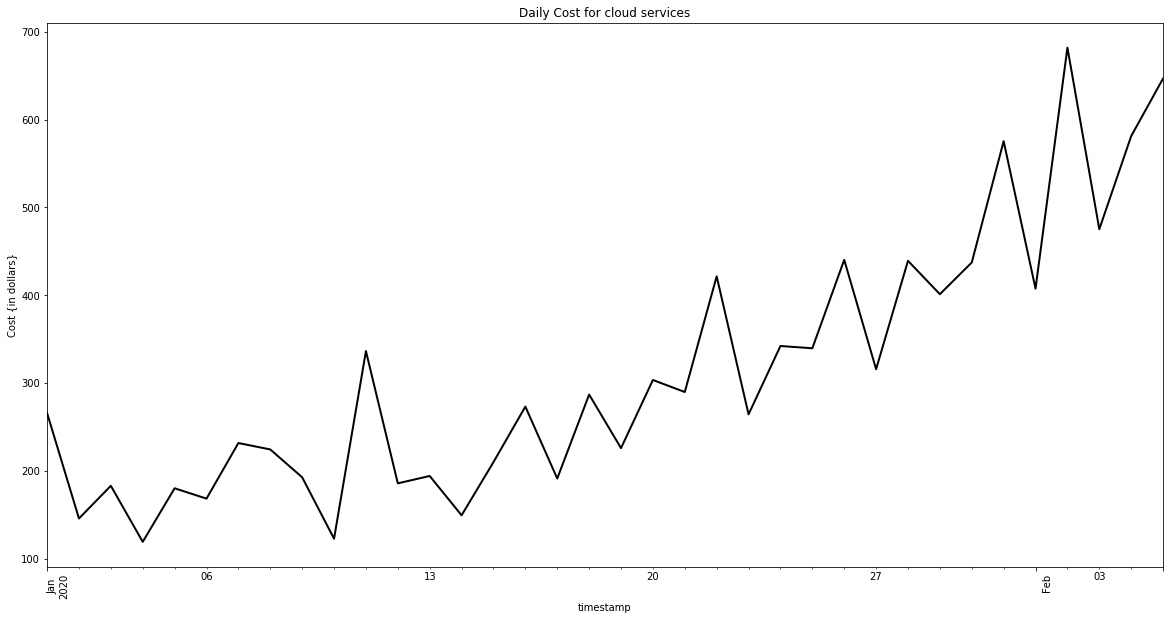

In [7]:
f, ax = plt.subplots(1,1, figsize = (20,10))
df.set_index('timestamp')['Cost'].plot(c='k', lw = 2, ax =ax)
plt.xticks(rotation=90)
plt.ylabel("Cost {in dollars}")
plt.title("Daily Cost for cloud services")
plt.show()

### 3. Split into Train and Test :
Splitting the dataset into Train (80%) and Test(20%)

In [8]:
train = df[0:int(len(df)*0.8)] 
test = df[int(len(df)*0.8):]

In [9]:
print(train.shape)
train.tail()

(28, 2)


,timestamp,Cost
23,2020-01-24,342.3
24,2020-01-25,339.7
25,2020-01-26,440.4
26,2020-01-27,315.9
27,2020-01-28,439.3


In [10]:
print(test.shape)
test.head()

(8, 2)


,timestamp,Cost
28,2020-01-29,401.3
29,2020-01-30,437.4
30,2020-01-31,575.5
31,2020-02-01,407.6
32,2020-02-02,682.0


In [11]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+29 for i in range(len(test))]

## 4. Build various models on the training data and compare the models.

### 4.1 Linear Regression
Linear regression is a linear model, a model that assumes a linear relationship between the input variables (X) and the single output variable (y). y can be calculated from a linear combination of the input variables (X).

In [12]:
LinearRegression_train = train.copy()
LinearRegression_test = test.copy()
LinearRegression_train['time'] = train_time
LinearRegression_test['time'] = test_time

In [13]:
LinearRegression_train

,timestamp,Cost,time
0,2020-01-01,266.0,1
1,2020-01-02,145.9,2
2,2020-01-03,183.1,3
3,2020-01-04,119.3,4
4,2020-01-05,180.3,5
5,2020-01-06,168.5,6
6,2020-01-07,231.8,7
7,2020-01-08,224.5,8
8,2020-01-09,192.8,9
9,2020-01-10,122.9,10


In [14]:
LinearRegression_test

,timestamp,Cost,time
28,2020-01-29,401.3,29
29,2020-01-30,437.4,30
30,2020-01-31,575.5,31
31,2020-02-01,407.6,32
32,2020-02-02,682.0,33
33,2020-02-03,475.3,34
34,2020-02-04,581.3,35
35,2020-02-05,646.9,36


In [15]:
lr = LinearRegression()
lr.fit(LinearRegression_train[['time']],LinearRegression_train['Cost'].values)
linear_train_predictions_model = lr.predict(LinearRegression_train[['time']])
LinearRegression_train['Predictions'] = linear_train_predictions_model
linear_test_predictions_model = lr.predict(LinearRegression_test[['time']])
LinearRegression_test['Predictions'] = linear_test_predictions_model

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 <a list of 10 Text xticklabel objects>)

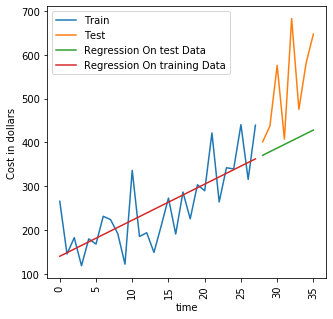

In [16]:
plt.figure(figsize=(5,5))
plt.plot( LinearRegression_train['Cost'], label='Train')
plt.plot(LinearRegression_test['Cost'], label='Test')
plt.plot(LinearRegression_test['Predictions'], label='Regression On test Data')
plt.plot(LinearRegression_train['Predictions'], label='Regression On training Data')
plt.legend(loc='upper left')
plt.xlabel("time")
plt.ylabel("Cost in dollars")
plt.xticks(rotation=90)

In [17]:
## Mean Absolute Error :
linear_mae_train = metrics.mean_absolute_error(LinearRegression_train['Cost'],linear_train_predictions_model)
print("Mean absolute error on Train Data is : ", round(linear_mae_train, 2))
linear_mae_test = metrics.mean_absolute_error(LinearRegression_test['Cost'],LinearRegression_test['Predictions'])
print("Mean absolute error on Test Data is : ", round(linear_mae_test, 2))
## Mean Squared Error :
linear_mse_model_train = metrics.mean_squared_error(LinearRegression_train['Cost'],linear_train_predictions_model)
print("Mean Squared Error on Train Data is :", round(linear_mse_model_train, 2))
linear_mse_model_test = metrics.mean_squared_error(LinearRegression_test['Cost'],LinearRegression_test['Predictions'])
print("Mean Squared Error on Test Data is : ", round(linear_mse_model_test, 2))
## Root Mean Squared Error :
linear_rmse_train = math.sqrt(linear_mse_model_train)
print("Root Mean Squared Error on Train Data is : ", round(linear_rmse_train, 2))
linear_rmse_test = math.sqrt(linear_mse_model_test)
print("Root Mean Squared Error on Test Data is : ", round(linear_rmse_test, 2))

Mean absolute error on Train Data is :  46.85
Mean absolute error on Test Data is :  126.44
Mean Squared Error on Train Data is : 3596.04
Mean Squared Error on Test Data is :  24420.07
Root Mean Squared Error on Train Data is :  59.97
Root Mean Squared Error on Test Data is :  156.27


### 4.2 Simple Exponential Smoothing
Simple exponential smoothing method is most suitable for forecasting data with no clear trend or seasonal pattern. It requires a single parameter, called alpha (a), also called the smoothing factor or smoothing coefficient.

In [18]:
ses_train = train.copy()
ses_test = test.copy()
ses_train['time'] = [i+1 for i in range(len(ses_train))]

In [19]:
ses_model = SimpleExpSmoothing(ses_train['Cost'])
ses_model_autofit = ses_model.fit(optimized=True, use_brute=True)
ses_model_autofit.params

{'smoothing_level': 0.33180739340422477,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 198.1712937002061,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [20]:
ses_train['Predictions'] = ses_model_autofit.fittedvalues
ses_test['Predictions'] = ses_model_autofit.forecast(len(ses_test))

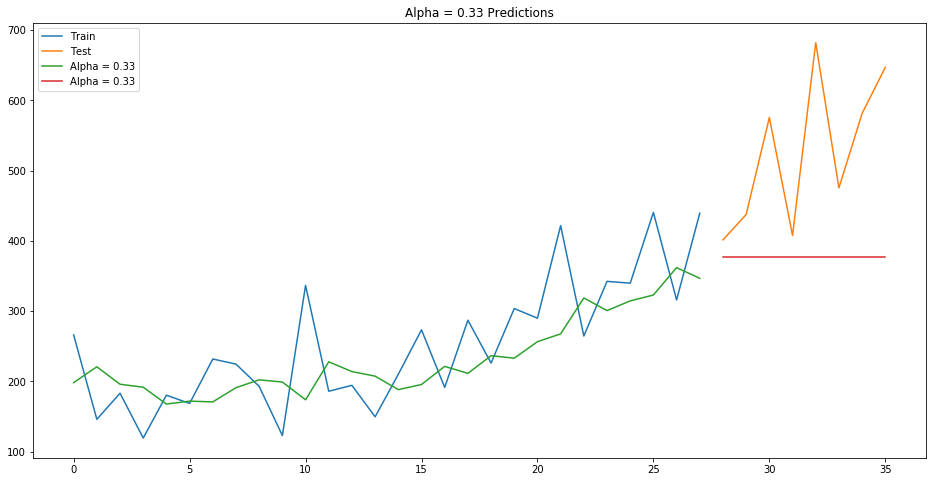

In [21]:
plt.figure(figsize=(16,8))
plt.plot(ses_train['Cost'], label='Train')
plt.plot(ses_test['Cost'], label='Test')
plt.plot(ses_train['Predictions'], label='Alpha = 0.33')
plt.plot(ses_test['Predictions'], label='Alpha = 0.33')
plt.legend(loc = 'best')
plt.title('Alpha = 0.33 Predictions')
plt.show()

As we can infer from the above graph, Single exponential smoothing only projects a straight horizontal line and does not capture trends well. And in order to capture the trends as well, we perform holt's method.

In [22]:
## Mean Squared Error :
ses_mse_model_train = metrics.mean_squared_error(ses_train['Cost'],ses_train['Predictions'])
print("Mean Squared Error on Train Data is :", round(ses_mse_model_train, 2))
ses_mse_model_test = metrics.mean_squared_error(ses_test['Cost'],ses_test['Predictions'])
print("Mean Squared Error on Test Data is : ", round(ses_mse_model_test, 2))
## Root Mean Squared Error :
ses_rmse_train = math.sqrt(ses_mse_model_train)
print("Root Mean Squared Error on Train Data is : ", round(ses_rmse_train, 2))
ses_rmse_test = math.sqrt(ses_mse_model_test)
print("Root Mean Squared Error on Test Data is : ", round(ses_rmse_test, 2))

Mean Squared Error on Train Data is : 4692.49
Mean Squared Error on Test Data is :  32622.8
Root Mean Squared Error on Train Data is :  68.5
Root Mean Squared Error on Test Data is :  180.62


For the given alpha the RMSE for the test data is very high. So we will move towards more techniques.

### 4.3 Double Exponential Smoothing : Holt's Model
Holt's Double Exponential Smoothing method is similar to Simple Exponential Smoothing. It calculates the level component to measure the level in the Forecast. It also adds the trend component to create a Linear trend in the Forecast

In [23]:
des_train = train.copy()
des_test = test.copy()
des_train['time'] = [i+1 for i in range(len(des_train))]

In [24]:
des_model = Holt(des_train['Cost'])
des_model_autofit = des_model.fit(optimized =True,use_brute=True)
des_model_autofit.summary()

Dep. Variable:,Cost,No. Observations:,28
Model:,Holt,SSE,100689.659
Optimized:,True,AIC,237.253
Trend:,Additive,BIC,242.581
Seasonal:,None,AICC,241.253
Seasonal Periods:,None,Date:,"Fri, 08 Jan 2021"
Box-Cox:,False,Time:,17:51:30
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,2.9751e-09,beta,True


In [25]:
des_train["Predictions"] = des_model_autofit.fittedvalues
des_test_predictions_model = des_model_autofit.forecast(steps=len(des_test))
des_test['Predictions'] = des_test_predictions_model
des_test

,timestamp,Cost,Predictions
28,2020-01-29,401.3,370.466792
29,2020-01-30,437.4,378.667889
30,2020-01-31,575.5,386.868986
31,2020-02-01,407.6,395.070083
32,2020-02-02,682.0,403.271180
33,2020-02-03,475.3,411.472277
34,2020-02-04,581.3,419.673374
35,2020-02-05,646.9,427.874471


In [26]:
## Mean Squared Error :
des_mse_model_train = metrics.mean_squared_error(des_train['Cost'], des_train['Predictions'])
print("Mean Squared Error on Train Data is : ", round(des_mse_model_train, 2))
des_mse_model_test = metrics.mean_squared_error(des_test['Cost'],des_test['Predictions'])
print("Mean Squared Error on Test Data is : ", round(des_mse_model_test, 2))
## Root Mean Squared Error :
des_rmse_train = math.sqrt(des_mse_model_train)
print("Root Mean Squared Error on Train Data is : ", round(des_rmse_train, 2))
des_rmse_test = math.sqrt(des_mse_model_test)
print("Root Mean Squared Error on Test Data is : ", round(des_rmse_test, 2))

Mean Squared Error on Train Data is :  3596.06
Mean Squared Error on Test Data is :  24499.74
Root Mean Squared Error on Train Data is :  59.97
Root Mean Squared Error on Test Data is :  156.52


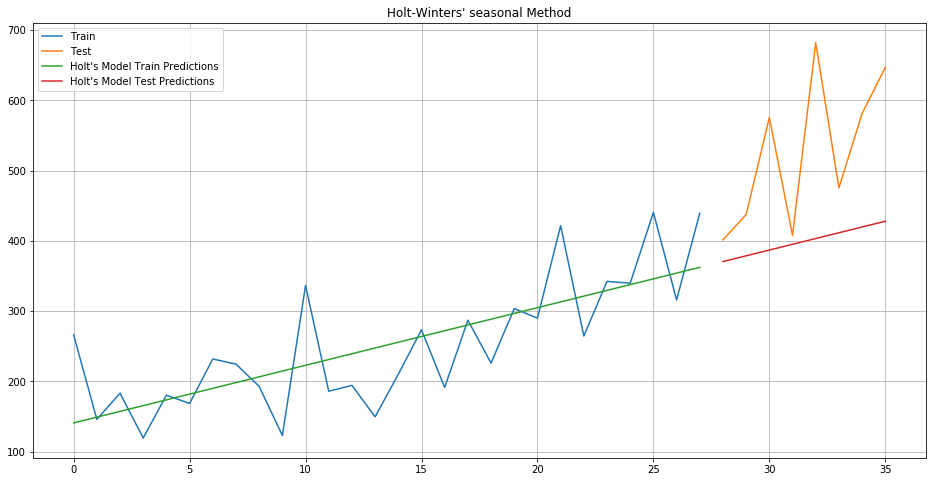

In [27]:
plt.figure(figsize=(16,8))
plt.plot(des_train['Cost'], label='Train')
plt.plot(des_test['Cost'], label='Test')
plt.plot(des_train['Predictions'], label="Holt's Model Train Predictions")
plt.plot(des_test['Predictions'], label="Holt's Model Test Predictions")
plt.legend(loc = 'best')
plt.title("Holt-Winters' seasonal Method")
plt.grid()

### Auto-correlation and Partial Auto-Correlation
- Auto-correlation : 
    * Relationship of a variable with its previous time values.
    * Direct and indirect effect of various in previous time values lags
    
- Partial Auto-correlation :
    * Only direct effect of values in previous time lags
    * Used to find the order for Auto Regression Model


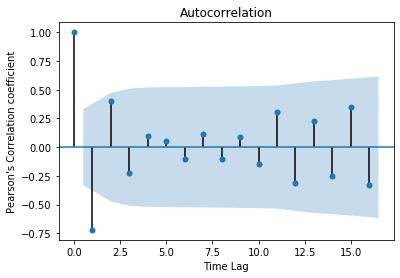

In [28]:
plot_acf(df['Cost'].diff().dropna())
plt.ylabel("Pearson's Correlation coefficient")
plt.xlabel("Time Lag")
plt.show()

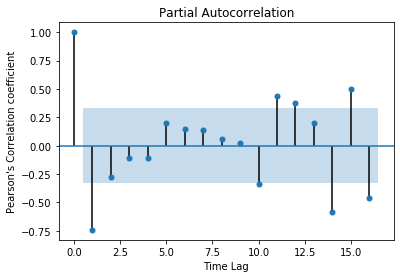

In [29]:
plot_pacf(df['Cost'].diff().dropna())
plt.ylabel("Pearson's Correlation coefficient")
plt.xlabel("Time Lag")
plt.show()

The above values of Pearson's Correlation Coefficient allows us to choose the cut off points for Arima model. We can now choose the params p and q i.e. the order of the A(auto regression) and MA(moving average) model between the range 0,2. And the param d i.e. the order of differencing for non-stationary to stationary can be kept as 1 in order to make the above time series stationary.

### 4.4 Automated ARIMA model :
'Auto Regressive Integrated Moving Average' is actually a class of models that 'explains' a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

In [30]:
p =  range(0, 3)
q = range(0, 2)
d = range(1,2)
pdq = list(itertools.product(p, d, q))
for i in range(1,len(pdq)):
    print('Model: {}'.format(pdq[i]))

Model: (0, 1, 1)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (2, 1, 0)
Model: (2, 1, 1)


In [31]:
arima_train = train.copy()
arima_test = test.copy()
arima_train["time"] = [i+1 for i in range(len(arima_train))]
arima_aic = pd.DataFrame(columns=['param','AIC'])

In [32]:
for param in pdq:
    arima_model = ARIMA(arima_train['Cost'].values, order=param).fit()
    print('ARIMA{} - AIC {} '.format(param,arima_model.aic))
    arima_aic = arima_aic.append({'param':param,'AIC': arima_model.aic}, ignore_index = True)

ARIMA(0, 1, 0) - AIC 324.4220452613395 
ARIMA(0, 1, 1) - AIC 308.0017065862927 
ARIMA(1, 1, 0) - AIC 309.11887677529 
ARIMA(1, 1, 1) - AIC 306.79093608912564 
ARIMA(2, 1, 0) - AIC 310.4797159942725 
ARIMA(2, 1, 1) - AIC 308.6750869738271 


In [33]:
arima_aic.sort_values(by='AIC', ascending=True)

,param,AIC
3,"(1, 1, 1)",306.790936
1,"(0, 1, 1)",308.001707
5,"(2, 1, 1)",308.675087
2,"(1, 1, 0)",309.118877
4,"(2, 1, 0)",310.479716
0,"(0, 1, 0)",324.422045


The Akaike Information Critera (AIC) is a widely used measure of a statistical model. It basically quantifies:
1. the goodness of fit
2. the simplicity/parsimony, of the model into a single statistic. When comparing two models, the one with the lower AIC is generally “better”. 
* We will choose the order with lowest AIC : (1,1,1)

In [34]:
model_111 = ARIMA(arima_train['Cost'], order=(1,1,1))
arima_results = model_111.fit()
print(arima_results.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.Cost   No. Observations:                   27
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -149.395
Method:                       css-mle   S.D. of innovations             59.706
Date:                Fri, 08 Jan 2021   AIC                            306.791
Time:                        17:51:31   BIC                            311.974
Sample:                             1   HQIC                           308.332
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            8.0673      2.874      2.807      0.005       2.435      13.699
ar.L1.D.Cost    -0.4363      0.210     -2.078      0.038      -0.848      -0.025
ma.L1.D.Cost    -0.6761      0.180     -3.76

In [35]:
arima_train['Predictions'] = arima_results.fittedvalues
arima_train = arima_train.fillna(0)
arima_train

,timestamp,Cost,time,Predictions
0,2020-01-01,266.0,1,0.000000
1,2020-01-02,145.9,2,8.067321
2,2020-01-03,183.1,3,98.256483
3,2020-01-04,119.3,4,27.702616
4,2020-01-05,180.3,5,95.715605
5,2020-01-06,168.5,6,7.519639
6,2020-01-07,231.8,7,29.565209
7,2020-01-08,224.5,8,-38.653639
8,2020-01-09,192.8,9,-6.350259
9,2020-01-10,122.9,10,42.527049


In [36]:
arima_predictions = arima_results.forecast(steps=len(test))
arima_predictions[0]

array([371.27475652, 412.53753103, 406.12330292, 420.50821291,
       425.81947896, 435.08913088, 442.63193317, 450.92807526])

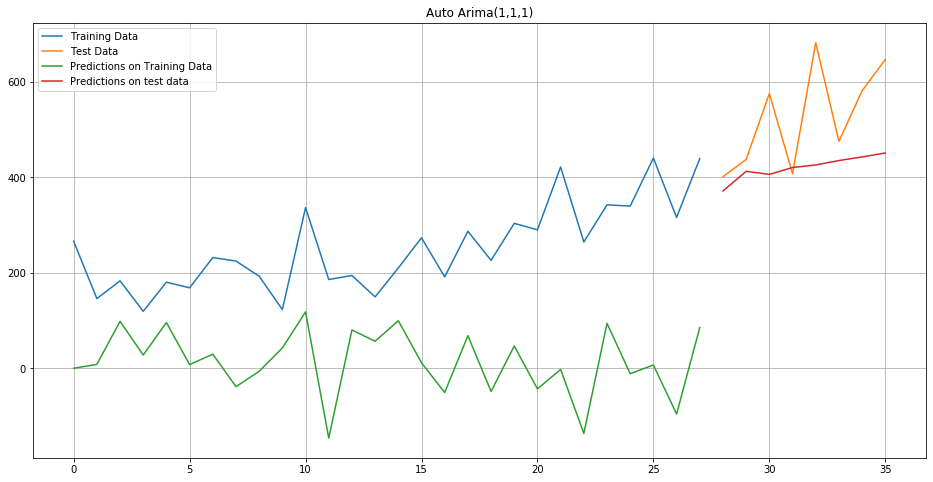

In [37]:
plt.figure(figsize=(16,8))
plt.plot(arima_train['Cost'], label = "Training Data")
plt.plot(arima_test['Cost'], label = "Test Data")
plt.plot(arima_train['Predictions'], label = "Predictions on Training Data")
plt.plot(test.index, arima_predictions[0], label = "Predictions on test data")
plt.legend(loc = "best")
plt.title("Auto Arima(1,1,1)")
plt.grid()

In [38]:
## Mean Squared Error :
arima_mse_model_train = metrics.mean_squared_error(arima_train['Cost'], arima_train['Predictions'])
print("Mean Squared Error on Test Data is : ", round(arima_mse_model_train, 2))
arima_mse_model_test = metrics.mean_squared_error(arima_test['Cost'],arima_predictions[0])
print("Mean Squared Error on Test Data is : ", round(arima_mse_model_test, 2))
## Root Mean Squared Error :
arima_rmse_train = math.sqrt(arima_mse_model_train)
print("Root Mean Squared Error on Train Data is : ", round(arima_rmse_train, 2))
arima_rmse_test = math.sqrt(arima_mse_model_test)
print("Root Mean Squared Error on Test Data is : ", round(arima_rmse_test, 2))

Mean Squared Error on Test Data is :  68660.18
Mean Squared Error on Test Data is :  19406.74
Root Mean Squared Error on Train Data is :  262.03
Root Mean Squared Error on Test Data is :  139.31


Although the data set has some seasonality and hence ARIMA is 
not the right option here. The reason behind developing the ARIMA model is to understand how different the model could be if seasonality is not considered.

#### Cone of confidence for training data: 95%

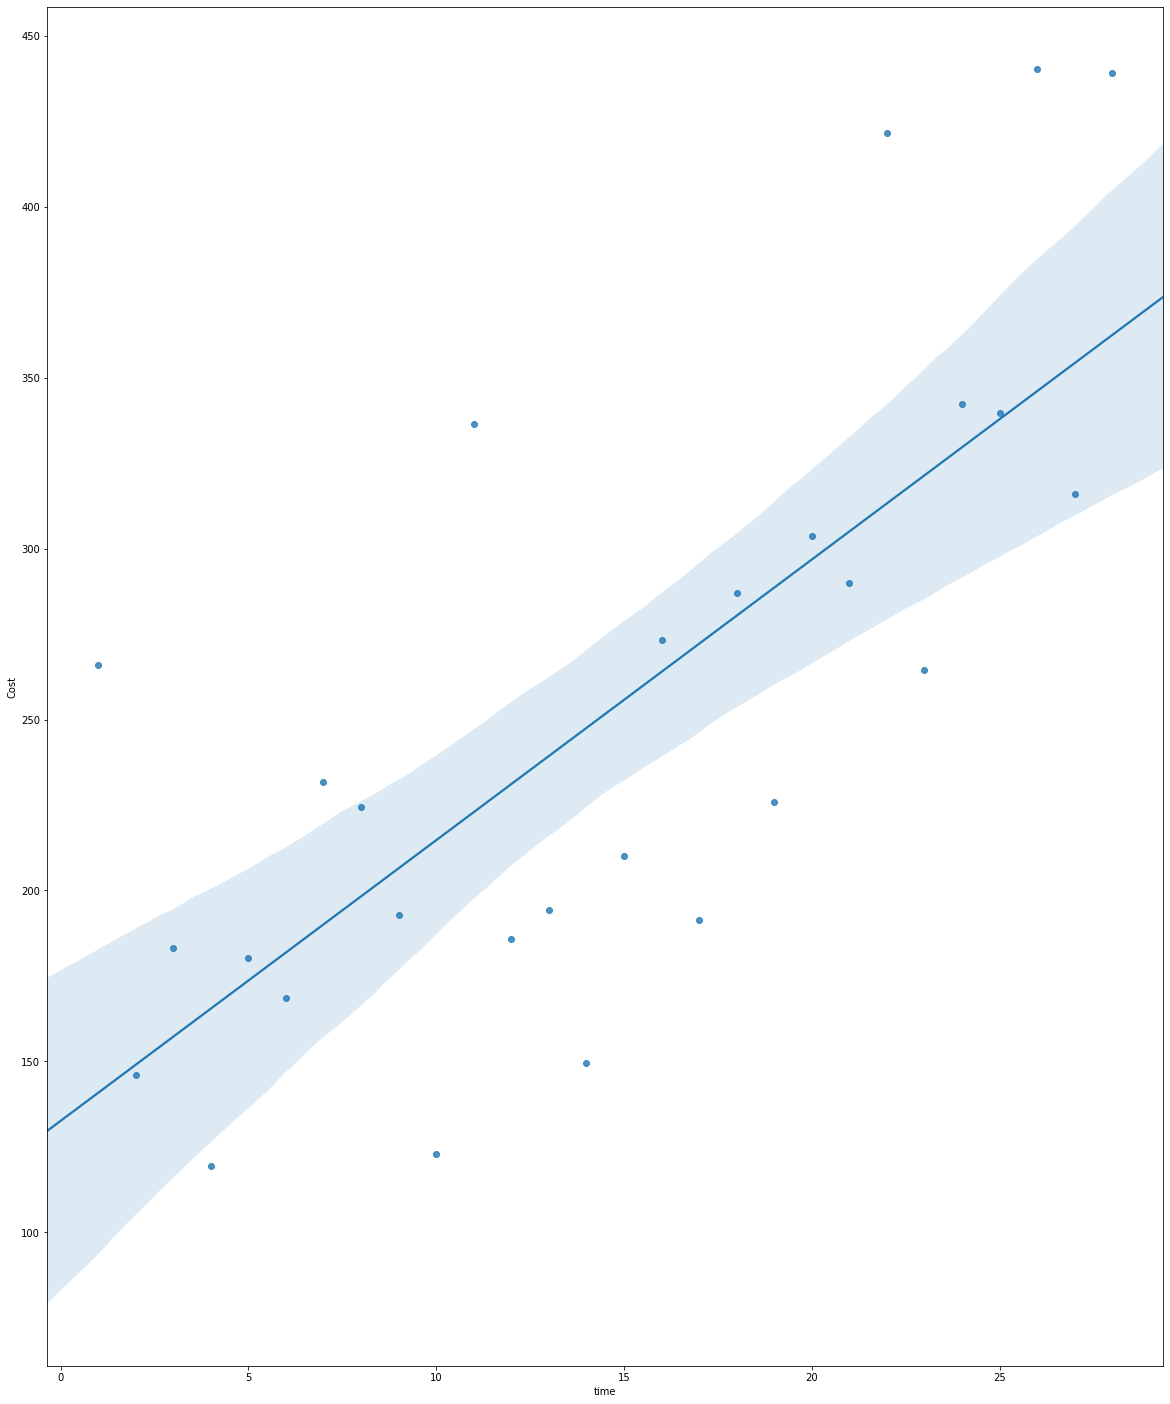

In [39]:
plt.figure(figsize=(20,25))
sns.regplot(arima_train['time'], arima_train['Cost'], ci =95)
plt.show()

### Confidence Interval for Predictions:
* We will calculate the lower and upper confidence bands at 95% confidence interval.
* Using the percentile function, we can calculate these by adding and subtracting from the predictions. This will give us the reqd confidence bands for the predictions.

In [40]:
preds_df = pd.DataFrame({"Lower" : arima_predictions[0] - ((np.percentile(arima_predictions[0],[2.5,97.5])))[0],
                        "Predictions" : arima_predictions[0],
                        "Upper" : arima_predictions[0] + ((np.percentile(arima_predictions[0],[2.5,97.5])))[1]})

In [41]:
preds_df

,Lower,Predictions,Upper
0,-6.098496,371.274757,820.751007
1,35.164279,412.537531,862.013781
2,28.750051,406.123303,855.599553
3,43.134961,420.508213,869.984463
4,48.446227,425.819479,875.295729
5,57.715879,435.089131,884.565381
6,65.258681,442.631933,892.108184
7,73.554823,450.928075,900.404326


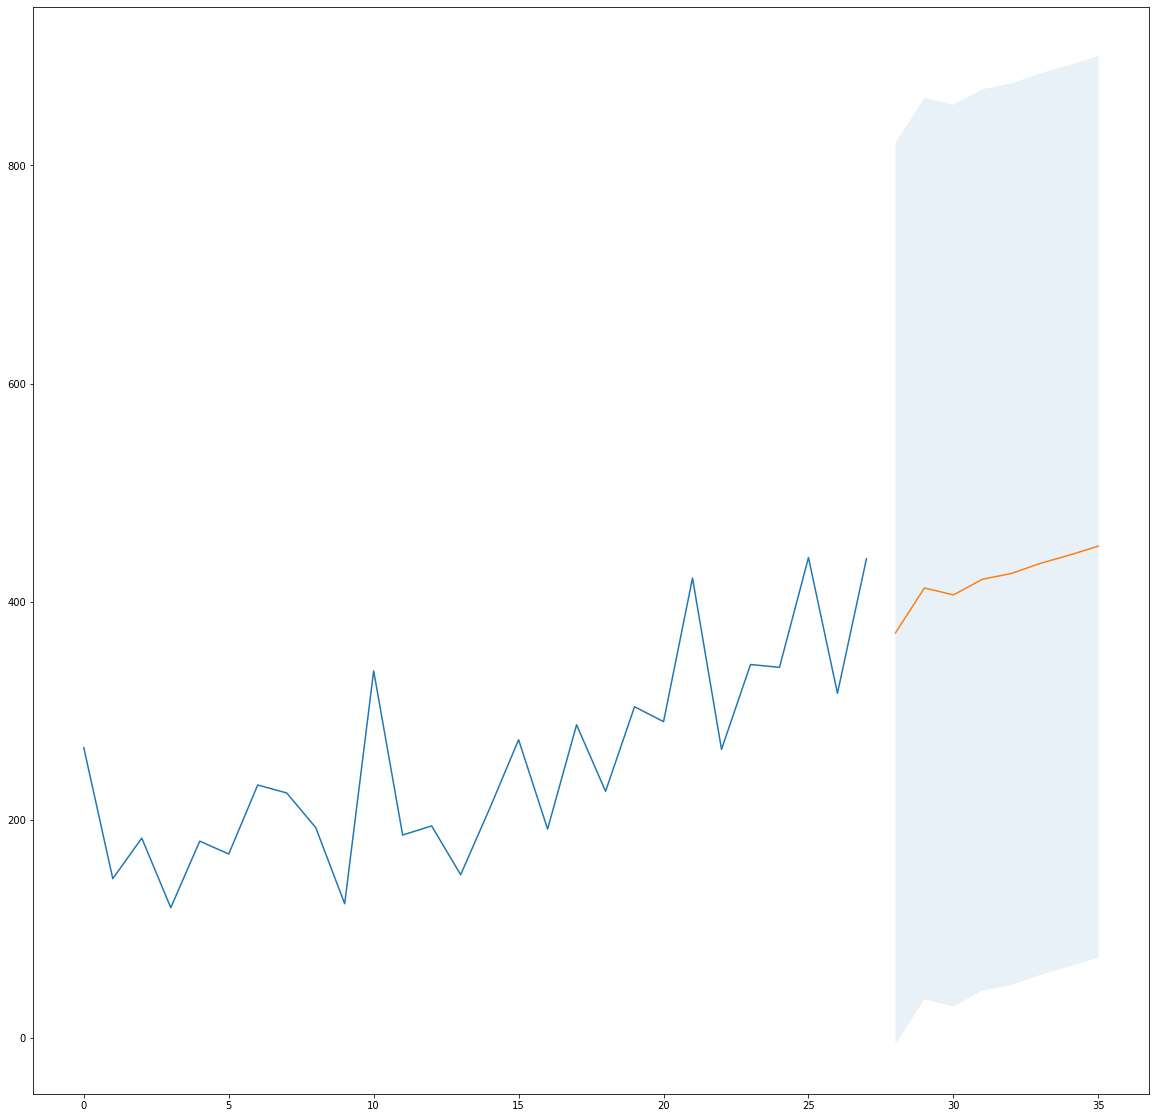

In [42]:
axis = arima_train["Cost"].plot(label = "Actual", figsize = (20,20))
plt.plot(test.index, preds_df["Predictions"], label = "Predictions on test data")
axis.fill_between(test.index, preds_df["Lower"], preds_df["Upper"], alpha =0.1)

## Conclusion :
* In this notebook, we have tried various Time-Series Forecasting Techniques like : Linear Regression, Simple Exponential Smoothing, Holt's Exponential Model and ARIMA. 
* We have best accuracies for Linear Regression and ARIMA. 
* These results could vary based on the trends and seasonality of the time series data.
* In future work, SARIMA will be tried out since we didn't get great results for this dataset using ARIMA.